In [1]:
!nvidia-smi

Sun Mar  9 16:27:52 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.04             Driver Version: 570.124.04     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX 4000 Ada Gene...    Off |   00000000:01:00.0 Off |                  Off |
| 30%   40C    P8             11W /  130W |     149MiB /  20475MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
from mingpt.bpe import BPETokenizer
from mingpt.model import GPT

import torch
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt

/users/eleves-a/2022/brahim.touayouch/projects/MiniGPT/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class StoryDataset:
    def __init__(self, data, tokenizer, block_size=128):
        self.tokenizer = tokenizer
        self.block_size = block_size
        self.data1 = [
            self.format_example(data_point["text"]) for data_point in data
        ]

    def format_example(self, text):
        tokens = self.tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=self.block_size)
        tokens = tokens.squeeze(0)
        
        return tokens

    def __len__(self):
        return len(self.data1)

    def __getitem__(self, idx):
        """
        Returns:
            x (torch.Tensor): Input tokens (question + answer prompt).
            y (torch.Tensor): Target tokens (shifted output).
        """
        # Handle both single index and list of indices
        if isinstance(idx, int):  # Single index
            tokens = self.data1[idx]
            x = tokens[:-1].clone().detach()
            y = tokens[1:].clone().detach()
            return x, y
        
        elif isinstance(idx, list) or isinstance(idx, torch.Tensor):  # Batch case
            batch_tokens = [self.data1[i] for i in idx]
            x_batch = [tokens[:-1].clone().detach() for tokens in batch_tokens]
            y_batch = [tokens[1:].clone().detach() for tokens in batch_tokens]
            return x_batch, y_batch
        
        else:
            raise TypeError(f"Invalid index type: {type(idx)}")


In [4]:
data = load_dataset('roneneldan/TinyStories')
data_frame = pd.DataFrame(data["train"])

In [5]:
data_frame

,text
0,"One day, a little girl named Lily found a need..."
1,"Once upon a time, there was a little car named..."
2,"One day, a little fish named Fin was swimming ..."
3,"Once upon a time, in a land full of trees, the..."
4,"Once upon a time, there was a little girl name..."
...,...
2119714,"Once upon a time, in a small town, there lived..."
2119715,"Once upon a time, there was a little boy named..."
2119716,"Once upon a time, there was a big tree. Under ..."
2119717,"Once upon a time, there was a little girl name..."


In [6]:
data_frame.iloc[0]['text']

'One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.\n\nLily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."\n\nTogether, they shared the needle and sewed the button on Lily\'s shirt. It was not difficult for them because they were sharing and helping each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together.'

In [7]:
train_testvalid = data["train"].train_test_split(test_size=0.9, seed=42)

# Split temp into validation and test
test_valid = train_testvalid["test"].train_test_split(test_size=0.5, seed=42)

# Final datasets
train_data = train_testvalid["train"]
val_data = test_valid["train"]
test_data = test_valid["test"]

# Print sizes
print(f"Train size: {len(train_data)}, Validation size: {len(val_data)}, Test size: {len(test_data)}")


Train size: 211971, Validation size: 953874, Test size: 953874


In [8]:
tokenizer = BPETokenizer()

train_dataset = StoryDataset(train_data.select(range(10001)), tokenizer=tokenizer, block_size=256)
test_dataset = StoryDataset(test_data.select(range(10001)), tokenizer=tokenizer, block_size=256)
val_dataset = StoryDataset(val_data.select(range(10001)), tokenizer=tokenizer, block_size=256)

In [9]:
model_type = 'gpt2'
device = 'cuda'

model = GPT.from_pretrained(model_type)
model.to(device)

number of parameters: 124.44M


GPT(
  (transformer): ModuleDict(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear(in_features=768, out_features=768, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): ModuleDict(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          (act): NewGELU()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(

In [10]:
def generate(prompt='', num_samples=1, steps=20, do_sample=True):
    tokenizer = BPETokenizer()

    if prompt == '':
        x = torch.tensor([[tokenizer.encoder.encoder['<|endoftext|>']]], dtype=torch.long)
    else:
        x = tokenizer(prompt, return_tensors='pt', padding=True, truncation=True, max_length=len(prompt.split())).to(device)

    x = x.expand(num_samples, -1)

    y = model.generate(x, max_new_tokens=steps, do_sample=do_sample, top_k=40)

    endoftext_token_id = tokenizer.encoder.encoder['<|endoftext|>']  # Get the ID of <|endoftext|> token

    for i in range(num_samples):
        # Decode the generated tokens
        out = tokenizer.decode(y[i].cpu().squeeze())

        # Check if the output contains the <|endoftext|> token and stop generating when encountered
        out_tokens = y[i].cpu().squeeze().tolist()
        
        # Find the position of <|endoftext|> token in the generated output
        if endoftext_token_id in out_tokens:
            end_pos = out_tokens.index(endoftext_token_id)
            out = tokenizer.decode(y[i].cpu().squeeze()[:end_pos])  # Slice the output up to <|endoftext|> token

        print('\n' + '-' * 80)
        print(out)

# Before finetuning

In [11]:
generate(prompt='One day, a little girl named Lily found a', num_samples=2, steps=50)


--------------------------------------------------------------------------------
One day, a little girl named Lily found a gift of hers on eBay. She was so curious about those gifts. I wonder about that little girl that was a bit different, like the first thing she saw her mom and the things she liked about her to know about her. I wonder what

--------------------------------------------------------------------------------
One day, a little girl named Lily found her baby on a tree. We've never had a lot of time to see Lily, and I believe it's important to her, since I never saw her on my own land.

To do this she needed to be in the village.


In [12]:
generate(prompt='One day,', num_samples=2, steps=50)


--------------------------------------------------------------------------------
One day we're waiting around a corner. And our first day we're sitting in our corner waiting. The first day of being in the big world.

I feel like I made the big world but, you know, there's always going to be

--------------------------------------------------------------------------------
One day, while we were talking to each other, I noticed the name of the person with whom I was:

B.

Pleased. I found his face so very, very cute. He knew it.

I was glad to


# Finetuning

In [13]:
from mingpt.trainer import Trainer

train_config = Trainer.get_default_config()
train_config.learning_rate = 5e-5
train_config.batch_size = 24
train_config.max_iters = 10
train_config.num_workers = 0
train_config.eval_interval = 1
train_config.log_iter = 100
def collate_fn(batch):
    x_batch, y_batch = zip(*batch)
    return torch.stack(x_batch), torch.stack(y_batch)

train_config.collate_fn = collate_fn
trainer = Trainer(train_config, model, train_dataset, val_dataset)

Running on device cuda


In [14]:
losses = []
def batch_end_callback(trainer):
    losses.append(trainer.loss.item())
    if trainer.iter_num % 100 == 0:
        print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}\n")
trainer.set_callback('on_batch_end', batch_end_callback)

trainer.run()

Training Progress:  10%|█         | 1/10 [00:00<00:02,  4.33it/s]

Validation Loss: 5.1377


Training Progress:  20%|██        | 2/10 [01:33<07:21, 55.17s/it]

iter_dt 0.00ms; iter 0: train loss 5.57287

Validation Loss: 2.9475


Training Progress:  30%|███       | 3/10 [03:08<08:31, 73.12s/it]

Validation Loss: 2.0841


Training Progress:  40%|████      | 4/10 [04:42<08:09, 81.57s/it]

Validation Loss: 1.8546


Training Progress:  50%|█████     | 5/10 [06:17<07:11, 86.31s/it]

Validation Loss: 1.7772


Training Progress:  60%|██████    | 6/10 [07:52<05:56, 89.20s/it]

Validation Loss: 1.7382


Training Progress:  70%|███████   | 7/10 [09:27<04:32, 90.97s/it]

Validation Loss: 1.7173


Training Progress:  80%|████████  | 8/10 [11:01<03:04, 92.13s/it]

Validation Loss: 1.7030


Training Progress:  90%|█████████ | 9/10 [12:36<01:32, 92.89s/it]

Validation Loss: 1.6902


Training Progress: 100%|██████████| 10/10 [14:10<00:00, 93.41s/it]

Validation Loss: 1.6786


Training Progress: 100%|██████████| 10/10 [15:45<00:00, 94.53s/it]

Training finished!


# After Finetung

In [15]:
generate(prompt='One day, a little girl named Lily found a', num_samples=2, steps=50)


--------------------------------------------------------------------------------
One day, a little girl named Lily found herself on a beach. Looking up at the beach, Lily asked her if she could make her own sponge cake. Lily nodded and said she could, but it would not do anything for her. She asked the sponge cake what to do. Lily felt

--------------------------------------------------------------------------------
One day, a little girl named Lily found a cupcake on the ground and made it. She took two small pieces and put them back in her kitchen and gave them to her mom. The cake made a lovely little muffin and sat in her dad's room. Lily thought it must be


In [16]:
generate(prompt='One day,', num_samples=2, steps=50)


--------------------------------------------------------------------------------
One day, I walked into the office, and on a very sunny day it was sunny and green. It was so cool, and the water was so refreshing. In the evenings, my wife and I would go to the beach and have a meal together.

--------------------------------------------------------------------------------
One day, the kids found their room, filled with toys to read, play, and eat, and watch TV shows. By the time they were all done with their toys, they were ready to leave.

But one day, someone started making sure


# Evaluations

### Training Loss

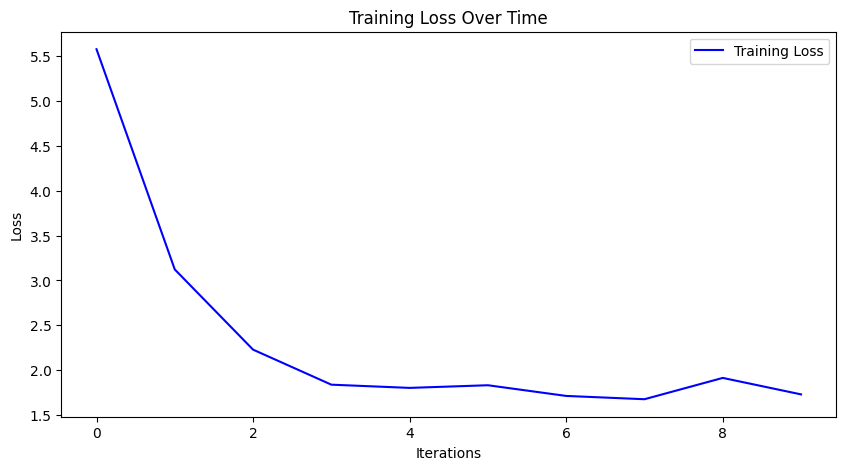

In [18]:
def plot_loss(iterations, losses):
    """Plot the loss after training."""
    plt.figure(figsize=(10, 5))
    plt.plot(iterations, losses, label="Training Loss", color='blue')
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Time")
    plt.legend()
    plt.show()

plot_loss(range(10), losses)

### Validation Loss

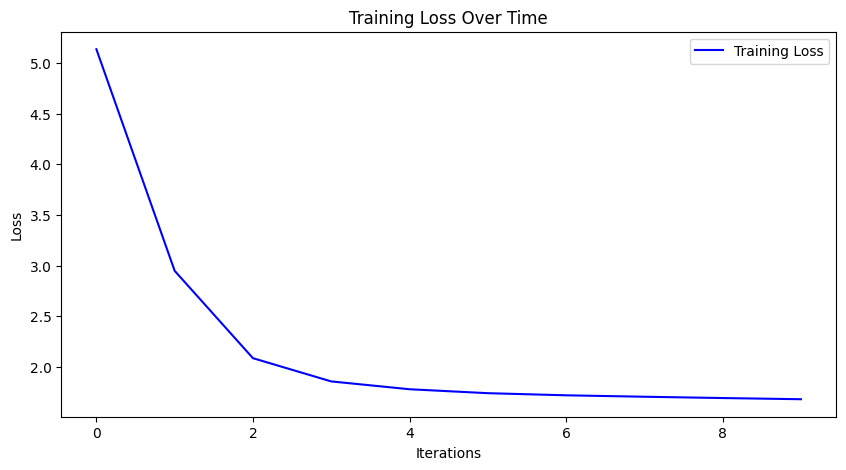

In [19]:
plot_loss(range(10), trainer.val_losses)

### Test Loss and Perplexity Evaluation

In [20]:
import torch
from torch.utils.data import DataLoader

@torch.no_grad()
def evaluate(model, test_dataset, batch_size=24, device='cuda'):
    model.eval()  # Set model to evaluation mode
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    total_loss = 0.0
    num_batches = 0

    for batch in test_loader:
        batch = [t.to(device) for t in batch]
        x, y = batch
        logits, loss = model(x, y)

        total_loss += loss.item()
        num_batches += 1

    avg_loss = total_loss / num_batches
    perplexity = torch.exp(torch.tensor(avg_loss))
    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Perplexity: {perplexity:.4f}")
    return avg_loss, perplexity

In [21]:
test_loss, perplexity = evaluate(model=model, test_dataset=test_dataset)

Test Loss: 1.6681
Perplexity: 5.3021
